#  <font color='red'>Setup Colab Environment</font>

In [ ]:
import pandas as pd
import numpy as np
import requests
import itertools
import os
import sys
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from PIL import Image
import skimage.io
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,BatchNormalization,GlobalMaxPooling2D,concatenate,Flatten
from keras.callbacks.callbacks import EarlyStopping,ReduceLROnPlateau,Callback
from keras.initializers import random_normal
from keras.models import load_model
from keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
from keras import backend as K

import tensorflow as tf
#import shap

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

2  CPU cores


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# Importing Libraries
#ref - https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Fynd_challenge')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/My Drive/Fynd_challenge


#  <font color='red'>EDA on data and visualize sample images</font>

In [ ]:
df = pd.read_csv('fynd_data.csv')
print(df.shape)
df.head(4)

(2156, 7)


id  ...   class
0  3213e9e9da734c268db6bed4b76ea411.jpg  ...  zipper
1  3a4e9c2704bb46afb5a43c3231974e04.jpg  ...  zipper
2  48d93cb06ede452fbab83495a4ff17a6.jpg  ...  zipper
3  c7d91a112c6341eb84ed8e62ea4d6aa8.jpg  ...  zipper

[4 rows x 7 columns]

In [ ]:
df.isnull().sum()

id         0
view_1     0
view_2     1
view_3     5
view_4     6
view_5    37
class      0
dtype: int64

In [ ]:
df = df.dropna()
print(df.shape)

(2113, 7)


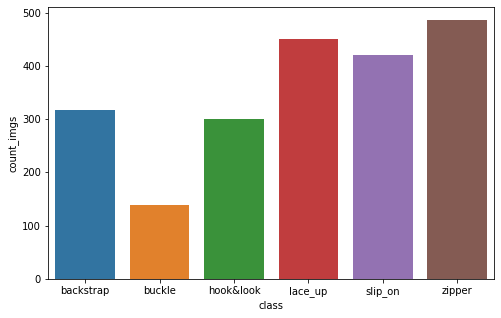

In [ ]:
df_grp = pd.DataFrame(df.groupby('class').size()).reset_index()
df_grp.columns  = ['class','count_imgs']
plt.figure(figsize = (8,5))
sns.barplot(x = 'class',y = 'count_imgs',data = df_grp)
plt.show()

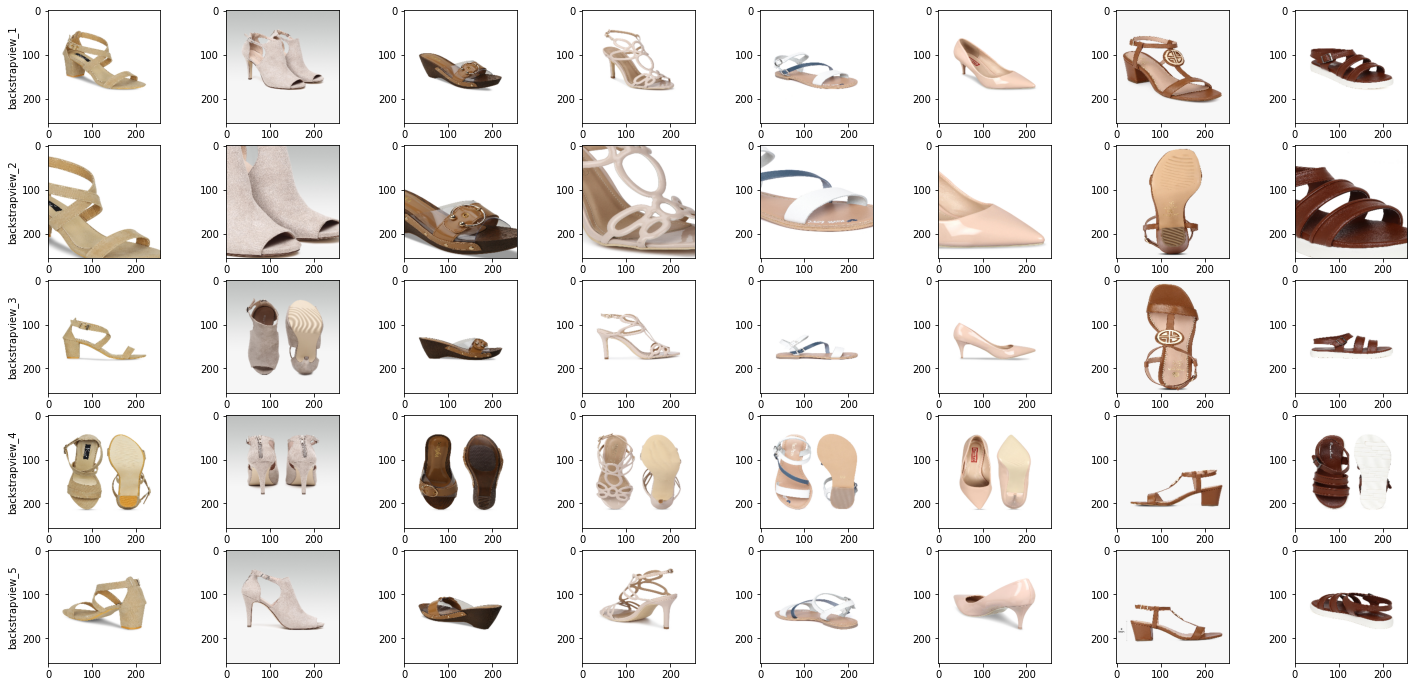

In [ ]:
f, axarr = plt.subplots(5,8,figsize = (25,12))
for view in range(1,6):
  colname = "view_" + str(view)
  axarr[view-1][0].set_ylabel("backstrap" + colname)
  for i in range(8):
    df_temp = df[df['class'] == 'backstrap']
    try:
      img = cv2.resize(skimage.io.imread(df_temp[colname].iloc[i]),(256,256))
    except:
      continue
    axarr[view-1][i].imshow(img)

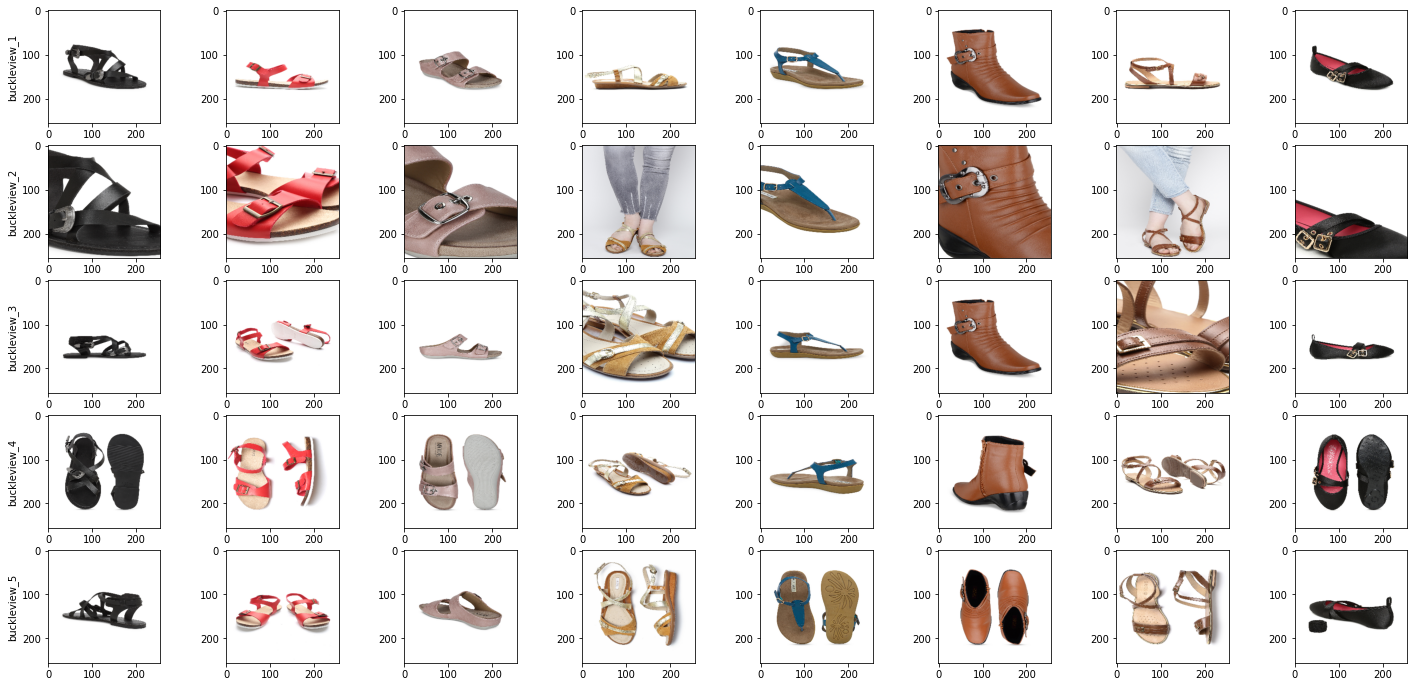

In [ ]:
f, axarr = plt.subplots(5,8,figsize = (25,12))
for view in range(1,6):
  colname = "view_" + str(view)
  axarr[view-1][0].set_ylabel("buckle" + colname)
  for i in range(8):
    df_temp = df[df['class'] == 'buckle']
    try:
      img = cv2.resize(skimage.io.imread(df_temp[colname].iloc[i]),(256,256))
    except:
      continue
    axarr[view-1][i].imshow(img)

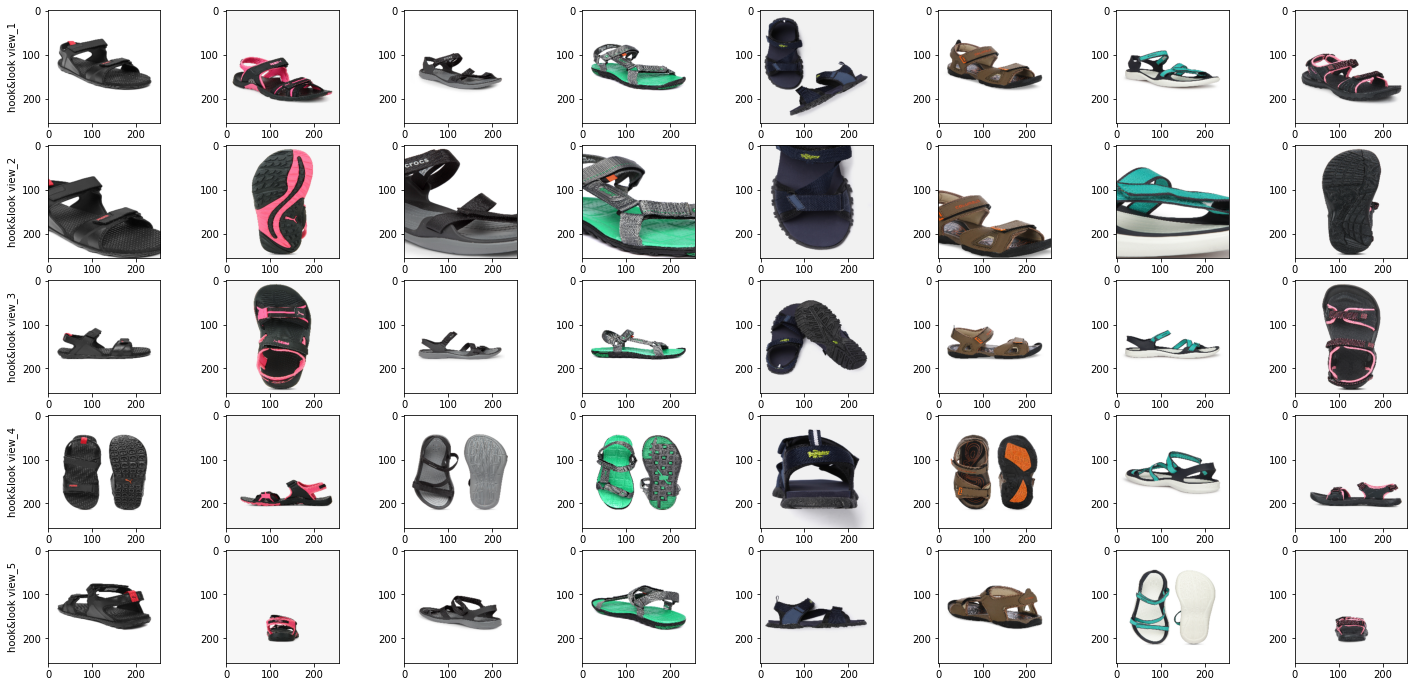

In [ ]:
f, axarr = plt.subplots(5,12,figsize = (25,12))
for view in range(1,6):
  colname = "view_" + str(view)
  axarr[view-1][0].set_ylabel("hook&look " + colname)
  for i in range(12):
    df_temp = df[df['class'] == 'hook&look']
    try:
      img = cv2.resize(skimage.io.imread(df_temp[colname].iloc[i]),(256,256))
    except:
      continue
    axarr[view-1][i].imshow(img)

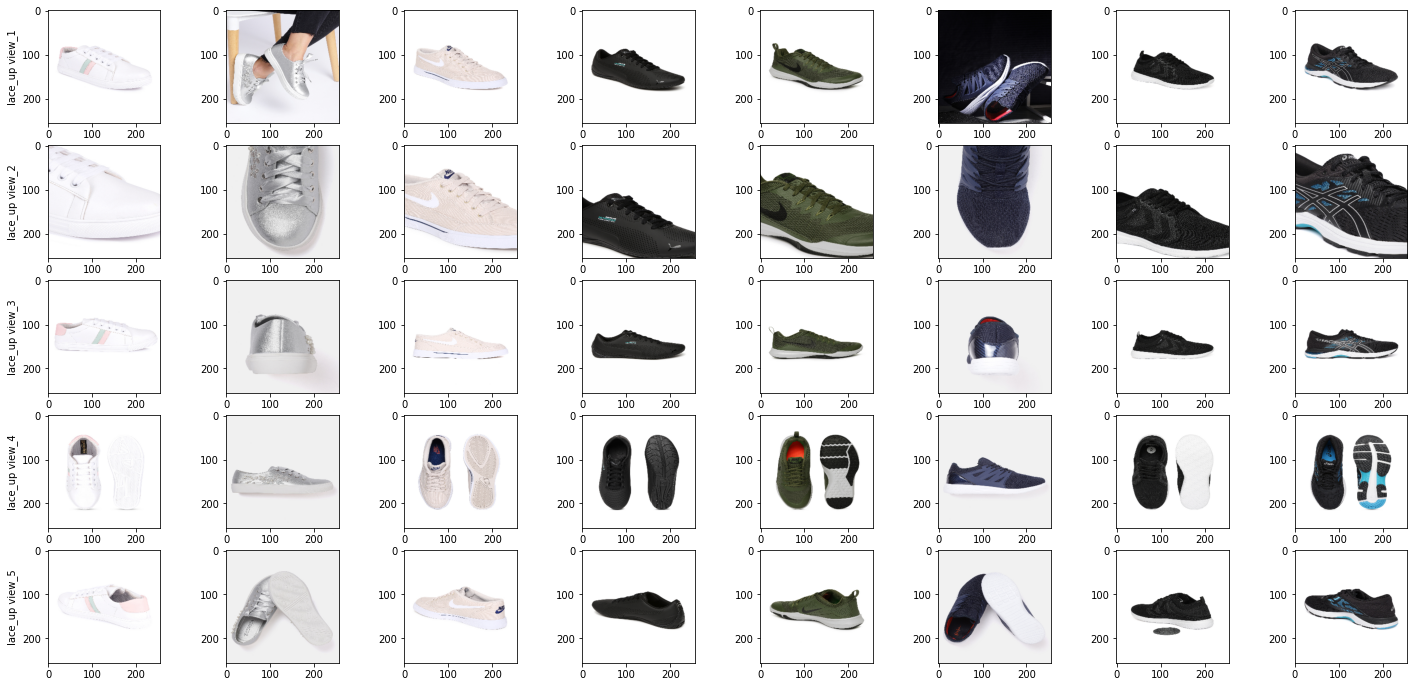

In [ ]:
f, axarr = plt.subplots(5,12,figsize = (25,12))
for view in range(1,6):
  colname = "view_" + str(view)
  axarr[view-1][0].set_ylabel("lace_up " + colname)
  for i in range(12):
    df_temp = df[df['class'] == 'lace_up']
    try:
      img = cv2.resize(skimage.io.imread(df_temp[colname].iloc[i]),(256,256))
    except:
      continue
    axarr[view-1][i].imshow(img)

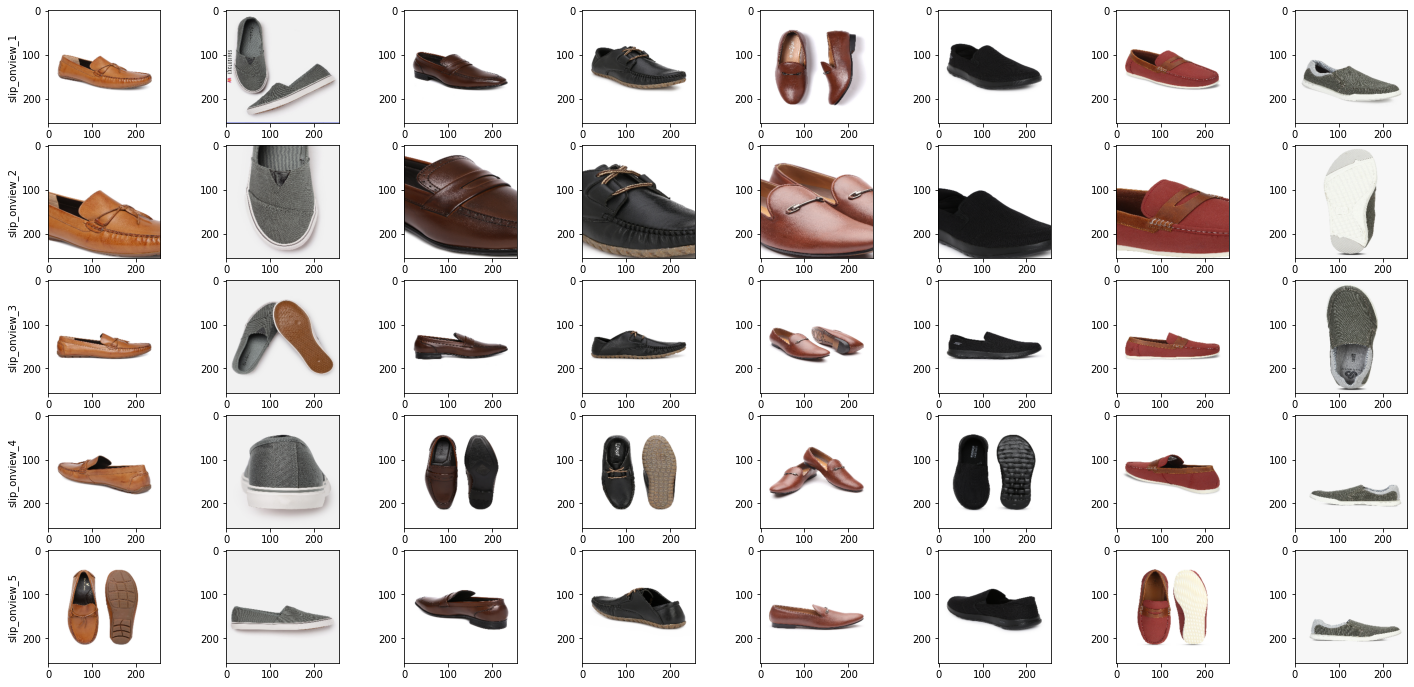

In [ ]:
f, axarr = plt.subplots(5,12,figsize = (25,12))
for view in range(1,6):
  colname = "view_" + str(view)
  axarr[view-1][0].set_ylabel("slip_on" + colname)
  for i in range(12):
    df_temp = df[df['class'] == 'slip_on']
    try:
      img = cv2.resize(skimage.io.imread(df_temp[colname].iloc[i]),(256,256))
    except:
      continue
    axarr[view-1][i].imshow(img)

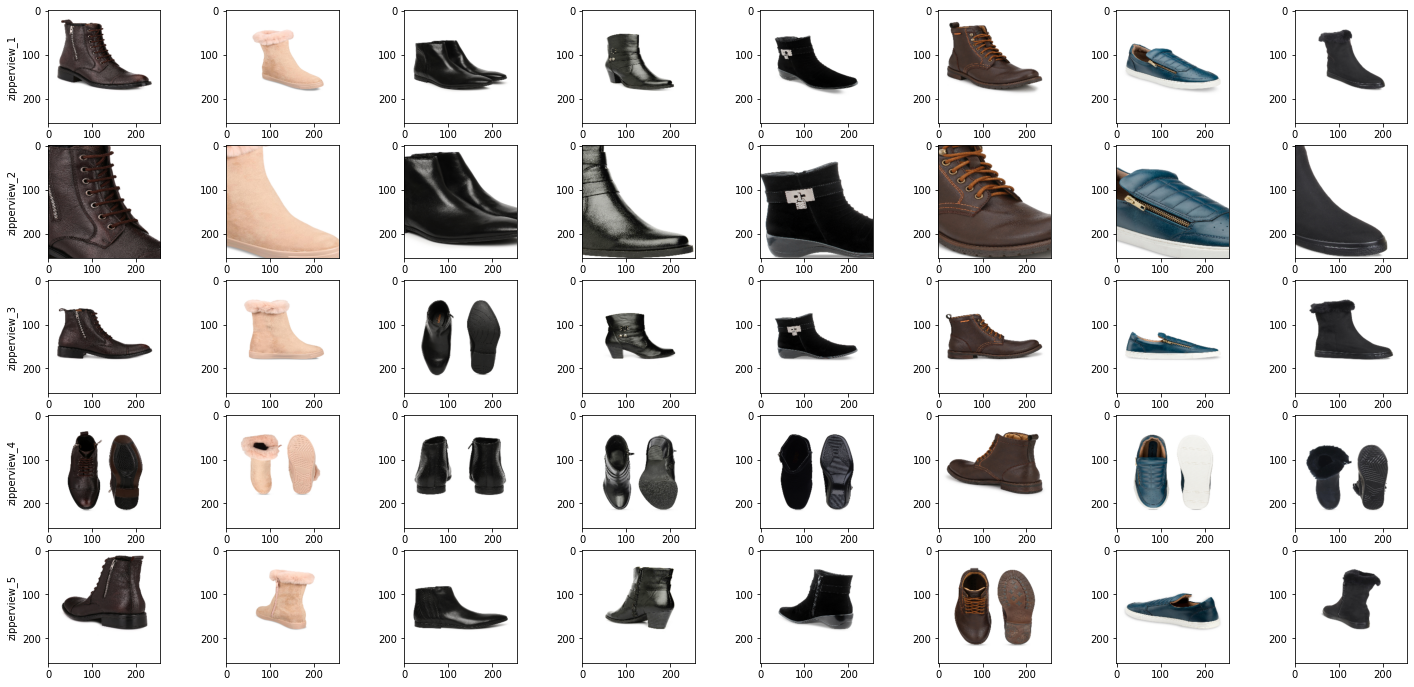

In [ ]:
f, axarr = plt.subplots(5,12,figsize = (25,12))
for view in range(1,6):
  colname = "view_" + str(view)
  axarr[view-1][0].set_ylabel("zipper" + colname)
  for i in range(12):
    df_temp = df[df['class'] == 'zipper']
    try:
      img = cv2.resize(skimage.io.imread(df_temp[colname].iloc[i]),(256,256))
    except:
      continue
    axarr[view-1][i].imshow(img)

#  <font color='red'>Train test split</font>

In [ ]:
df_train,df_test = train_test_split(df,test_size = 0.25)
print(df.shape,df_train.shape,df_test.shape)

(2113, 7) (1584, 7) (529, 7)


In [ ]:
df_output_encodings = pd.DataFrame({'class' : df_train['class'].unique(),'label' : list(range(6))})
df_output_encodings

class  label
0  backstrap      0
1  hook&look      1
2     zipper      2
3    slip_on      3
4    lace_up      4
5     buckle      5

In [ ]:
df_train = df_train.merge(df_output_encodings,on = 'class',how = 'left')
df_test = df_test.merge(df_output_encodings,on = 'class',how = 'left')

In [ ]:
'''
file = open('df_train', 'wb')
pickle.dump(df_train, file)
file.close()

file = open('df_test', 'wb')
pickle.dump(df_test, file)
file.close()
'''
file = open('df_train', 'rb')
df_train = pickle.load(file)
file.close()

file = open('df_test', 'rb')
df_test = pickle.load(file)
file.close()

print(df_train.shape,df_test.shape)

(1584, 8) (529, 8)


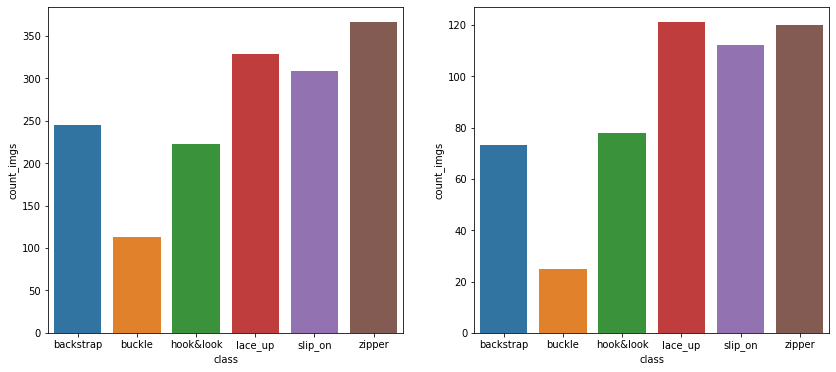

In [ ]:
df_grp_train = pd.DataFrame(df_train.groupby('class').size()).reset_index()
df_grp_train.columns  = ['class','count_imgs']
df_grp_test = pd.DataFrame(df_test.groupby('class').size()).reset_index()
df_grp_test.columns  = ['class','count_imgs']

f, axarr = plt.subplots(1,2,figsize = (14,6))
axarr[0].set_xlabel("TRANING")
axarr[1].set_xlabel("TEST")
sns.barplot(y="count_imgs", x= "class", data=df_grp_train,  orient='v' , ax=axarr[0])
sns.barplot(y="count_imgs", x= "class", data=df_grp_test,  orient='v' , ax=axarr[1])
plt.show()

#  <font color='red'>Get Images from URLs to numpy.ndarray</font>


In [ ]:
def image_downloader(path):
    try:
        img = np.expand_dims(cv2.resize(skimage.io.imread(path),(256,256)),0)
    except Exception:
        print('Error in Fetching Image_URL')
    return img

def multiprocess_image_downloader(process:int, urls:list):
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_downloader, urls)
    return results

In [ ]:
y_train = keras.utils.to_categorical(df_train['label'],6)
y_test = keras.utils.to_categorical(df_test['label'],6)
print(y_train.shape,y_test.shape)

(1584, 6) (529, 6)


In [ ]:
y_train_encoded = np.vstack((y_train,y_train,y_train,y_train,y_train))
y_test_encoded = np.vstack((y_test,y_test,y_test,y_test,y_test))
print(y_train_encoded.shape,y_test_encoded.shape)

(7920, 6) (2645, 6)


In [ ]:
'''
file = open('y_train_encoded', 'wb')
pickle.dump(y_train_encoded, file)
file.close()

file = open('y_test_encoded', 'wb')
pickle.dump(y_test_encoded, file)
file.close()
'''

"\nfile = open('y_train_encoded', 'wb')\npickle.dump(y_train_encoded, file)\nfile.close()\n\nfile = open('y_test_encoded', 'wb')\npickle.dump(y_test_encoded, file)\nfile.close()\n"

###  <font color='red'>View 1</font>


In [ ]:
X_train_1 = np.array([])
for i in tqdm_notebook(range(8)):
  imgs = multiprocess_image_downloader(2, list(df_train[(198*i):198*(i+1)].view_1.values))
  X_train_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_train_temp = np.concatenate((X_train_temp,imgiter),axis = 0) if len(X_train_temp) > 0 else imgiter
  X_train_temp = X_train_temp.astype('float32')/255
  X_train_1 = np.concatenate((X_train_1,X_train_temp),axis = 0) if len(X_train_1) > 0 else X_train_temp
  print(X_train_1.shape)

print(X_train_1.shape)
np.savez_compressed('X_train_1.npz', X_train_1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(198, 256, 256, 3)
MESSAGE: Running 2 process



(396, 256, 256, 3)
MESSAGE: Running 2 process



(594, 256, 256, 3)
MESSAGE: Running 2 process



(792, 256, 256, 3)
MESSAGE: Running 2 process



(990, 256, 256, 3)
MESSAGE: Running 2 process



(1188, 256, 256, 3)
MESSAGE: Running 2 process



(1386, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)



In [ ]:
X_test_1 = np.array([])
for i in tqdm_notebook(range(23)):
  imgs = multiprocess_image_downloader(2, list(df_test[(23*i):23*(i+1)].view_1.values))
  X_test_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_test_temp = np.concatenate((X_test_temp,imgiter),axis = 0) if len(X_test_temp) > 0 else imgiter
  X_test_temp = X_test_temp.astype('float32')/255
  X_test_1 = np.concatenate((X_test_1,X_test_temp),axis = 0) if len(X_test_1) > 0 else X_test_temp
  print(X_test_1.shape)

print(X_test_1.shape)
np.savez_compressed('X_test_1.npz', X_test_1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(23, 256, 256, 3)
MESSAGE: Running 2 process



(46, 256, 256, 3)
MESSAGE: Running 2 process



(69, 256, 256, 3)
MESSAGE: Running 2 process



(92, 256, 256, 3)
MESSAGE: Running 2 process



(115, 256, 256, 3)
MESSAGE: Running 2 process



(138, 256, 256, 3)
MESSAGE: Running 2 process



(161, 256, 256, 3)
MESSAGE: Running 2 process



(184, 256, 256, 3)
MESSAGE: Running 2 process



(207, 256, 256, 3)
MESSAGE: Running 2 process



(230, 256, 256, 3)
MESSAGE: Running 2 process



(253, 256, 256, 3)
MESSAGE: Running 2 process



(276, 256, 256, 3)
MESSAGE: Running 2 process



(299, 256, 256, 3)
MESSAGE: Running 2 process



(322, 256, 256, 3)
MESSAGE: Running 2 process



(345, 256, 256, 3)
MESSAGE: Running 2 process



(368, 256, 256, 3)
MESSAGE: Running 2 process



(391, 256, 256, 3)
MESSAGE: Running 2 process



(414, 256, 256, 3)
MESSAGE: Running 2 process



(437, 256, 256, 3)
MESSAGE: Running 2 process



(460, 256, 256, 3)
MESSAGE: Running 2 process



(483, 256, 256, 3)
MESSAGE: Running 2 process



(506, 256, 256, 3)
MESSAGE: Running 2 process



(529, 256, 256, 3)

(529, 256, 256, 3)


###  <font color='red'>View 2</font>


In [ ]:
X_train_2 = np.array([])
for i in tqdm_notebook(range(8)):
  imgs = multiprocess_image_downloader(2, list(df_train[(198*i):198*(i+1)].view_2.values))
  X_train_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_train_temp = np.concatenate((X_train_temp,imgiter),axis = 0) if len(X_train_temp) > 0 else imgiter
  X_train_temp = X_train_temp.astype('float32')/255
  X_train_2 = np.concatenate((X_train_2,X_train_temp),axis = 0) if len(X_train_2) > 0 else X_train_temp
  print(X_train_2.shape)

print(X_train_2.shape)
np.savez_compressed('X_train_2.npz', X_train_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(198, 256, 256, 3)
MESSAGE: Running 2 process



(396, 256, 256, 3)
MESSAGE: Running 2 process



(594, 256, 256, 3)
MESSAGE: Running 2 process



(792, 256, 256, 3)
MESSAGE: Running 2 process



(990, 256, 256, 3)
MESSAGE: Running 2 process



(1188, 256, 256, 3)
MESSAGE: Running 2 process



(1386, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)

(1584, 256, 256, 3)


In [ ]:
X_test_2 = np.array([])
for i in tqdm_notebook(range(23)):
  imgs = multiprocess_image_downloader(2, list(df_test[(23*i):23*(i+1)].view_2.values))
  X_test_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_test_temp = np.concatenate((X_test_temp,imgiter),axis = 0) if len(X_test_temp) > 0 else imgiter
  X_test_temp = X_test_temp.astype('float32')/255
  X_test_2 = np.concatenate((X_test_2,X_test_temp),axis = 0) if len(X_test_2) > 0 else X_test_temp
  print(X_test_2.shape)

print(X_test_2.shape)
np.savez_compressed('X_test_2.npz', X_test_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(23, 256, 256, 3)
MESSAGE: Running 2 process



(46, 256, 256, 3)
MESSAGE: Running 2 process



(69, 256, 256, 3)
MESSAGE: Running 2 process



(92, 256, 256, 3)
MESSAGE: Running 2 process



(115, 256, 256, 3)
MESSAGE: Running 2 process



(138, 256, 256, 3)
MESSAGE: Running 2 process



(161, 256, 256, 3)
MESSAGE: Running 2 process



(184, 256, 256, 3)
MESSAGE: Running 2 process



(207, 256, 256, 3)
MESSAGE: Running 2 process



(230, 256, 256, 3)
MESSAGE: Running 2 process



(253, 256, 256, 3)
MESSAGE: Running 2 process



(276, 256, 256, 3)
MESSAGE: Running 2 process



(299, 256, 256, 3)
MESSAGE: Running 2 process



(322, 256, 256, 3)
MESSAGE: Running 2 process



(345, 256, 256, 3)
MESSAGE: Running 2 process



(368, 256, 256, 3)
MESSAGE: Running 2 process



(391, 256, 256, 3)
MESSAGE: Running 2 process



(414, 256, 256, 3)
MESSAGE: Running 2 process



(437, 256, 256, 3)
MESSAGE: Running 2 process



(460, 256, 256, 3)
MESSAGE: Running 2 process



(483, 256, 256, 3)
MESSAGE: Running 2 process



(506, 256, 256, 3)
MESSAGE: Running 2 process



(529, 256, 256, 3)

(529, 256, 256, 3)


###  <font color='red'>View 3</font>


In [ ]:
X_train_3 = np.array([])
for i in tqdm_notebook(range(8)):
  imgs = multiprocess_image_downloader(2, list(df_train[(198*i):198*(i+1)].view_3.values))
  X_train_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_train_temp = np.concatenate((X_train_temp,imgiter),axis = 0) if len(X_train_temp) > 0 else imgiter
  X_train_temp = X_train_temp.astype('float32')/255
  X_train_3 = np.concatenate((X_train_3,X_train_temp),axis = 0) if len(X_train_3) > 0 else X_train_temp
  print(X_train_3.shape)

print(X_train_3.shape)
np.savez_compressed('X_train_3.npz', X_train_3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(198, 256, 256, 3)
MESSAGE: Running 2 process



(396, 256, 256, 3)
MESSAGE: Running 2 process



(594, 256, 256, 3)
MESSAGE: Running 2 process



(792, 256, 256, 3)
MESSAGE: Running 2 process



(990, 256, 256, 3)
MESSAGE: Running 2 process



(1188, 256, 256, 3)
MESSAGE: Running 2 process



(1386, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)

(1584, 256, 256, 3)


In [ ]:
X_test_3 = np.array([])
for i in tqdm_notebook(range(23)):
  imgs = multiprocess_image_downloader(2, list(df_test[(23*i):23*(i+1)].view_3.values))
  X_test_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_test_temp = np.concatenate((X_test_temp,imgiter),axis = 0) if len(X_test_temp) > 0 else imgiter
  X_test_temp = X_test_temp.astype('float32')/255
  X_test_3 = np.concatenate((X_test_3,X_test_temp),axis = 0) if len(X_test_3) > 0 else X_test_temp
  print(X_test_3.shape)

print(X_test_3.shape)
np.savez_compressed('X_test_3.npz', X_test_3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(23, 256, 256, 3)
MESSAGE: Running 2 process



(46, 256, 256, 3)
MESSAGE: Running 2 process



(69, 256, 256, 3)
MESSAGE: Running 2 process



(92, 256, 256, 3)
MESSAGE: Running 2 process



(115, 256, 256, 3)
MESSAGE: Running 2 process



(138, 256, 256, 3)
MESSAGE: Running 2 process



(161, 256, 256, 3)
MESSAGE: Running 2 process



(184, 256, 256, 3)
MESSAGE: Running 2 process



(207, 256, 256, 3)
MESSAGE: Running 2 process



(230, 256, 256, 3)
MESSAGE: Running 2 process



(253, 256, 256, 3)
MESSAGE: Running 2 process



(276, 256, 256, 3)
MESSAGE: Running 2 process



(299, 256, 256, 3)
MESSAGE: Running 2 process



(322, 256, 256, 3)
MESSAGE: Running 2 process



(345, 256, 256, 3)
MESSAGE: Running 2 process



(368, 256, 256, 3)
MESSAGE: Running 2 process



(391, 256, 256, 3)
MESSAGE: Running 2 process



(414, 256, 256, 3)
MESSAGE: Running 2 process



(437, 256, 256, 3)
MESSAGE: Running 2 process



(460, 256, 256, 3)
MESSAGE: Running 2 process



(483, 256, 256, 3)
MESSAGE: Running 2 process



(506, 256, 256, 3)
MESSAGE: Running 2 process



(529, 256, 256, 3)

(529, 256, 256, 3)


###  <font color='red'>View 4</font>


In [ ]:
X_train_4 = np.array([])
for i in tqdm_notebook(range(8)):
  imgs = multiprocess_image_downloader(2, list(df_train[(198*i):198*(i+1)].view_4.values))
  X_train_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_train_temp = np.concatenate((X_train_temp,imgiter),axis = 0) if len(X_train_temp) > 0 else imgiter
  X_train_temp = X_train_temp.astype('float32')/255
  X_train_4 = np.concatenate((X_train_4,X_train_temp),axis = 0) if len(X_train_4) > 0 else X_train_temp
  print(X_train_4.shape)

print(X_train_4.shape)
np.savez_compressed('X_train_4.npz', X_train_4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(198, 256, 256, 3)
MESSAGE: Running 2 process



(396, 256, 256, 3)
MESSAGE: Running 2 process



(594, 256, 256, 3)
MESSAGE: Running 2 process



(792, 256, 256, 3)
MESSAGE: Running 2 process



(990, 256, 256, 3)
MESSAGE: Running 2 process



(1188, 256, 256, 3)
MESSAGE: Running 2 process



(1386, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)

(1584, 256, 256, 3)


In [ ]:
X_test_4 = np.array([])
for i in tqdm_notebook(range(23)):
  imgs = multiprocess_image_downloader(2, list(df_test[(23*i):23*(i+1)].view_4.values))
  X_test_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_test_temp = np.concatenate((X_test_temp,imgiter),axis = 0) if len(X_test_temp) > 0 else imgiter
  X_test_temp = X_test_temp.astype('float32')/255
  X_test_4 = np.concatenate((X_test_4,X_test_temp),axis = 0) if len(X_test_4) > 0 else X_test_temp
  print(X_test_4.shape)

print(X_test_4.shape)
np.savez_compressed('X_test_4.npz', X_test_4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(23, 256, 256, 3)
MESSAGE: Running 2 process



(46, 256, 256, 3)
MESSAGE: Running 2 process



(69, 256, 256, 3)
MESSAGE: Running 2 process



(92, 256, 256, 3)
MESSAGE: Running 2 process



(115, 256, 256, 3)
MESSAGE: Running 2 process



(138, 256, 256, 3)
MESSAGE: Running 2 process



(161, 256, 256, 3)
MESSAGE: Running 2 process



(184, 256, 256, 3)
MESSAGE: Running 2 process



(207, 256, 256, 3)
MESSAGE: Running 2 process



(230, 256, 256, 3)
MESSAGE: Running 2 process



(253, 256, 256, 3)
MESSAGE: Running 2 process



(276, 256, 256, 3)
MESSAGE: Running 2 process



(299, 256, 256, 3)
MESSAGE: Running 2 process



(322, 256, 256, 3)
MESSAGE: Running 2 process



(345, 256, 256, 3)
MESSAGE: Running 2 process



(368, 256, 256, 3)
MESSAGE: Running 2 process



(391, 256, 256, 3)
MESSAGE: Running 2 process



(414, 256, 256, 3)
MESSAGE: Running 2 process



(437, 256, 256, 3)
MESSAGE: Running 2 process



(460, 256, 256, 3)
MESSAGE: Running 2 process



(483, 256, 256, 3)
MESSAGE: Running 2 process



(506, 256, 256, 3)
MESSAGE: Running 2 process



(529, 256, 256, 3)

(529, 256, 256, 3)


###  <font color='red'>View 5</font>


In [ ]:
X_train_5 = np.array([])
for i in tqdm_notebook(range(8)):
  imgs = multiprocess_image_downloader(2, list(df_train[(198*i):198*(i+1)].view_5.values))
  X_train_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_train_temp = np.concatenate((X_train_temp,imgiter),axis = 0) if len(X_train_temp) > 0 else imgiter
  X_train_temp = X_train_temp.astype('float32')/255
  X_train_5 = np.concatenate((X_train_5,X_train_temp),axis = 0) if len(X_train_5) > 0 else X_train_temp
  print(X_train_5.shape)

print(X_train_5.shape)
np.savez_compressed('X_train_5.npz', X_train_5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)
MESSAGE: Running 2 process



(1584, 256, 256, 3)

(1584, 256, 256, 3)


In [ ]:
X_test_5 = np.array([])
for i in tqdm_notebook(range(23)):
  imgs = multiprocess_image_downloader(2, list(df_test[(23*i):23*(i+1)].view_5.values))
  X_test_temp = np.array([])
  for imgiter in tqdm_notebook(imgs):
    X_test_temp = np.concatenate((X_test_temp,imgiter),axis = 0) if len(X_test_temp) > 0 else imgiter
  X_test_temp = X_test_temp.astype('float32')/255
  X_test_5 = np.concatenate((X_test_5,X_test_temp),axis = 0) if len(X_test_5) > 0 else X_test_temp
  print(X_test_5.shape)

print(X_test_5.shape)
np.savez_compressed('X_test_5.npz', X_test_5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


MESSAGE: Running 2 process


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



(23, 256, 256, 3)
MESSAGE: Running 2 process



(46, 256, 256, 3)
MESSAGE: Running 2 process



(69, 256, 256, 3)
MESSAGE: Running 2 process



(92, 256, 256, 3)
MESSAGE: Running 2 process



(115, 256, 256, 3)
MESSAGE: Running 2 process



(138, 256, 256, 3)
MESSAGE: Running 2 process



(161, 256, 256, 3)
MESSAGE: Running 2 process



(184, 256, 256, 3)
MESSAGE: Running 2 process



(207, 256, 256, 3)
MESSAGE: Running 2 process



(230, 256, 256, 3)
MESSAGE: Running 2 process



(253, 256, 256, 3)
MESSAGE: Running 2 process



(276, 256, 256, 3)
MESSAGE: Running 2 process



(299, 256, 256, 3)
MESSAGE: Running 2 process



(322, 256, 256, 3)
MESSAGE: Running 2 process



(345, 256, 256, 3)
MESSAGE: Running 2 process



(368, 256, 256, 3)
MESSAGE: Running 2 process



(391, 256, 256, 3)
MESSAGE: Running 2 process



(414, 256, 256, 3)
MESSAGE: Running 2 process



(437, 256, 256, 3)
MESSAGE: Running 2 process



(460, 256, 256, 3)
MESSAGE: Running 2 process



(483, 256, 256, 3)
MESSAGE: Running 2 process



(506, 256, 256, 3)
MESSAGE: Running 2 process



(529, 256, 256, 3)

(529, 256, 256, 3)


In [ ]:
data_files  = ['X_train_1.npz','X_train_2.npz','X_train_3.npz','X_train_4.npz','X_train_5.npz']

X_train = np.memmap('X_train.npz', dtype=np.float32, mode='w+', shape=(7920,256,256,3))
idx = 0
for data_file in tqdm_notebook(data_files):
  with np.load(data_file) as data:
    chunk = data['arr_0']
    X_train[idx:idx + len(chunk)] = chunk
    idx += len(chunk)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
data_files  = ['X_test_1.npz','X_test_2.npz','X_test_3.npz','X_test_4.npz','X_test_5.npz']

X_test = np.memmap('X_test.npz', dtype=np.float32, mode='w+', shape=(2645,256,256,3))
idx = 0
for data_file in tqdm_notebook(data_files):
  with np.load(data_file) as data:
    chunk = data['arr_0']
    X_test[idx:idx + len(chunk)] = chunk
    idx += len(chunk)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
#X_train = np.memmap('X_train.npz',dtype = 'float32',mode = 'r',shape = (7920,256,256,3))
#X_test = np.memmap('X_test.npz',dtype = 'float32',mode = 'r',shape = (2645,256,256,3))

print(X_train.shape,X_test.shape)

(7920, 256, 256, 3) (2645, 256, 256, 3)


In [ ]:
file = open('y_train_encoded', 'rb')
y_train_encoded = pickle.load(file)
file.close()

file = open('y_test_encoded', 'rb')
y_test_encoded = pickle.load(file)
file.close()

print(y_train_encoded.shape,y_test_encoded.shape)

(7920, 6) (2645, 6)


#  <font color='red'>Train CNN Model (Approach 1) - (Use all 5 views as single row elements)</font>


In [ ]:
input_tensor = Input(shape=(256,256,3))
base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
final_output = Dense(6, activation='softmax', name='final_output')(x)
model = Model(input_tensor, final_output)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [ ]:
for layer in model.layers:
  layer.trainable = False

for i in range(-4, 0):
  model.layers[i].trainable = True

In [ ]:
model.compile(loss=categorical_crossentropy,optimizer=optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
history1 = model.fit(X_train, y_train_encoded,
                     batch_size=64,
                     epochs=5,
                     verbose=1,
                     validation_data=(X_test, y_test_encoded))

Train on 7920 samples, validate on 2645 samples
Epoch 1/5
7920/7920 [==============================] - 394s 50ms/step - loss: 1.0756 - accuracy: 0.6414 - val_loss: 1.9235 - val_accuracy: 0.2117
Epoch 2/5
7920/7920 [==============================] - 362s 46ms/step - loss: 0.6681 - accuracy: 0.7528 - val_loss: 2.5071 - val_accuracy: 0.2117
Epoch 3/5
7920/7920 [==============================] - 362s 46ms/step - loss: 0.5822 - accuracy: 0.7857 - val_loss: 2.0295 - val_accuracy: 0.2117
Epoch 4/5
7920/7920 [==============================] - 354s 45ms/step - loss: 0.5027 - accuracy: 0.8152 - val_loss: 2.1325 - val_accuracy: 0.2117
Epoch 5/5
7920/7920 [==============================] - 343s 43ms/step - loss: 0.4502 - accuracy: 0.8335 - val_loss: 2.5888 - val_accuracy: 0.2117


In [ ]:
#model.save('model_warmup.h5')
model = load_model('model1.h5')

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

model.summary()
model.compile(loss=categorical_crossentropy,optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
history2 = model.fit(X_train,y_train_encoded,
                     batch_size = 32,
                     epochs = 40,
                     validation_data = (X_test,y_test_encoded),
                     callbacks = [es,rlop],
                     verbose=1).history

Train on 7920 samples, validate on 2645 samples
Epoch 1/40
7920/7920 [==============================] - 405s 51ms/step - loss: 0.4666 - accuracy: 0.8322 - val_loss: 4.0357 - val_accuracy: 0.2117
Epoch 2/40
7920/7920 [==============================] - 351s 44ms/step - loss: 0.1958 - accuracy: 0.9337 - val_loss: 2.7171 - val_accuracy: 0.2741
Epoch 3/40
7920/7920 [==============================] - 354s 45ms/step - loss: 0.1239 - accuracy: 0.9582 - val_loss: 1.8812 - val_accuracy: 0.5384
Epoch 4/40
7920/7920 [==============================] - 354s 45ms/step - loss: 0.0963 - accuracy: 0.9658 - val_loss: 1.9569 - val_accuracy: 0.6919
Epoch 5/40
7920/7920 [==============================] - 354s 45ms/step - loss: 0.0929 - accuracy: 0.9677 - val_loss: 0.7700 - val_accuracy: 0.8163
Epoch 6/40
7920/7920 [==============================] - 361s 46ms/step - loss: 0.0866 - accuracy: 0.9711 - val_loss: 0.6955 - val_accuracy: 0.7807
Epoch 7/40
7920/7920 [==============================] - 380s 48ms/step

In [ ]:
model.save('model1.h5')

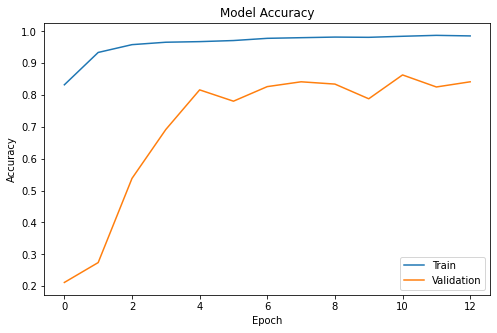

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.xlim((1, 15))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

#  <font color='red'>Evaluate Model</font>


In [ ]:
model = load_model('model1.h5')

In [ ]:
train_preds = model.predict(X_train,verbose = 1,batch_size = 32)
test_preds = model.predict(X_test,verbose = 1,batch_size = 32)

2645/2645 [==============================] - 78s 29ms/step


In [ ]:
train_labels = np.argmax(train_preds, axis=1)
test_labels = np.argmax(test_preds, axis=1)

In [ ]:
print("Train Accuracy score : %.3f" % accuracy_score(np.argmax(y_train_encoded,axis = 1),train_labels))
print("Test Accuracy score : %.3f" % accuracy_score(np.argmax(y_test_encoded,axis = 1),test_labels))

Train Accuracy score : 0.963
Test Accuracy score : 0.842


In [ ]:
def plot_conf_matrix(true,pred,classes,plot_title):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g').set_title(str(plot_title))
    plt.show()

In [ ]:
labels = ['0 - backstrap', '1 - hook&look', '2 - zipper', '3 - slip_on', '4 - lace_up','5 - buckle']

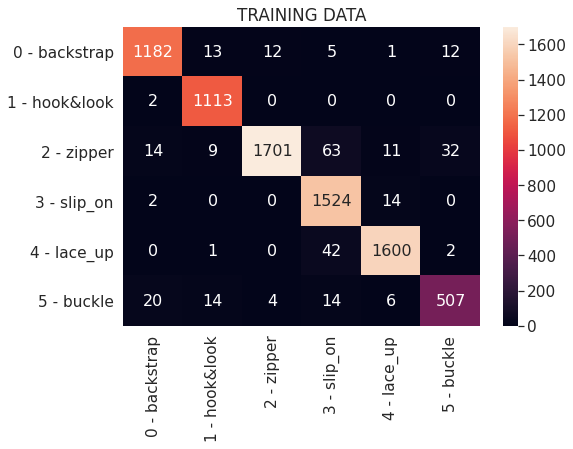

In [ ]:
plot_conf_matrix(np.argmax(y_train_encoded,axis = 1),train_labels,labels,"TRAINING DATA")

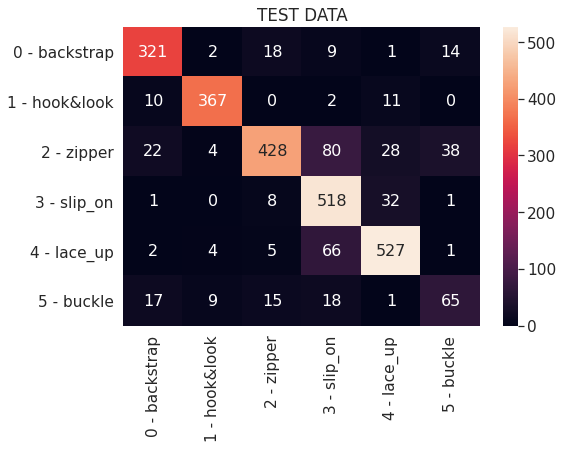

In [ ]:
plot_conf_matrix(np.argmax(y_test_encoded,axis = 1),test_labels,labels,"TEST DATA")

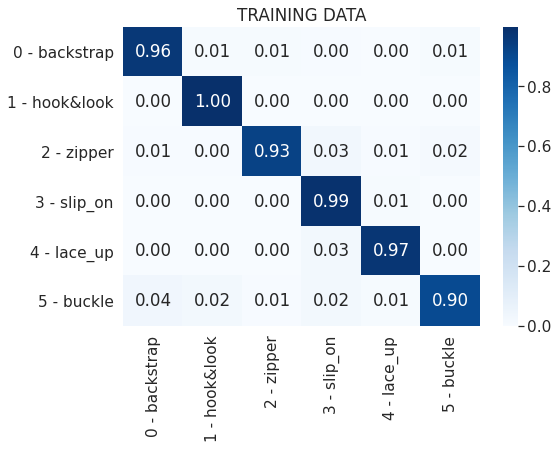

In [ ]:
cnf_matrix = confusion_matrix(np.argmax(y_train_encoded,axis = 1), train_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(8, 5.5))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues").set_title("TRAINING DATA")
plt.show()

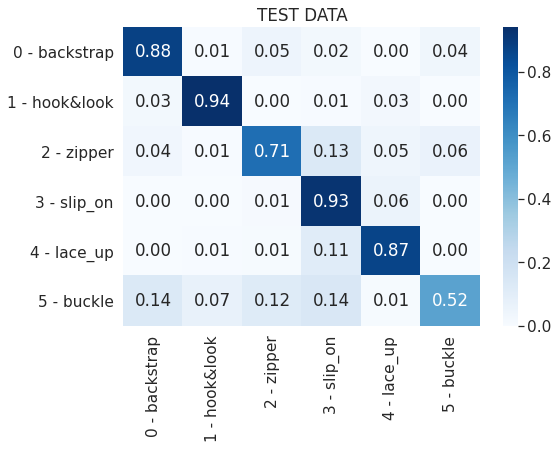

In [ ]:
cnf_matrix = confusion_matrix(np.argmax(y_test_encoded,axis = 1), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(8, 5.5))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues").set_title("TEST DATA")
plt.show()

#  <font color='red'>Summary and conclusions</font>


1. Buckle and zipper have low accuracies
2. Buckle has less data than other classes - we need to augment this using image-augmentations
3. The zip is not clear in most zipper images - need to zoom the data to get the zip clearly
4. Buckle - need to zoom the buckle images for the buckle to be visibly clear

#  <font color='red'>Hyperparameter tuning of model - Address overfitting</font>

In [ ]:
input_tensor = Input(shape=(256,256,3))
base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
final_output = Dense(6,kernel_regularizer= keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='softmax', name='final_output')(x)
model = Model(input_tensor, final_output)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
for layer in model.layers:
  layer.trainable = False

for i in range(-4, 0):
  model.layers[i].trainable = True

In [ ]:
model.compile(loss=categorical_crossentropy,optimizer=optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
history1 = model.fit(X_train, y_train_encoded,
                     batch_size=64,
                     epochs=2,
                     verbose=1,
                     validation_data=(X_test, y_test_encoded))

Train on 7920 samples, validate on 2645 samples
Epoch 1/2
7920/7920 [==============================] - 382s 48ms/step - loss: 1.0531 - accuracy: 0.6071 - val_loss: 2.2491 - val_accuracy: 0.2117
Epoch 2/2
7920/7920 [==============================] - 346s 44ms/step - loss: 0.7533 - accuracy: 0.7245 - val_loss: 2.2642 - val_accuracy: 0.2117


In [ ]:
for layer in model.layers:
  layer.trainable = True

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

model.summary()
model.compile(loss=categorical_crossentropy,optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
history2 = model.fit(X_train,y_train_encoded,
                     batch_size = 32,
                     epochs = 40,
                     validation_data = (X_test,y_test_encoded),
                     callbacks = [es,rlop],
                     verbose=1).history

Train on 7920 samples, validate on 2645 samples
Epoch 1/40
7920/7920 [==============================] - 658s 83ms/step - loss: 0.5572 - accuracy: 0.8020 - val_loss: 3.2395 - val_accuracy: 0.2117
Epoch 2/40
7920/7920 [==============================] - 636s 80ms/step - loss: 0.2829 - accuracy: 0.9019 - val_loss: 1.8756 - val_accuracy: 0.3331
Epoch 3/40
7920/7920 [==============================] - 632s 80ms/step - loss: 0.1779 - accuracy: 0.9389 - val_loss: 1.8775 - val_accuracy: 0.4972
Epoch 4/40
7920/7920 [==============================] - 635s 80ms/step - loss: 0.1374 - accuracy: 0.9532 - val_loss: 0.7751 - val_accuracy: 0.7902
Epoch 5/40
7920/7920 [==============================] - 633s 80ms/step - loss: 0.0935 - accuracy: 0.9693 - val_loss: 1.0375 - val_accuracy: 0.7580
Epoch 6/40
7920/7920 [==============================] - 633s 80ms/step - loss: 0.1073 - accuracy: 0.9626 - val_loss: 0.7418 - val_accuracy: 0.8261
Epoch 7/40
7920/7920 [==============================] - 632s 80ms/step

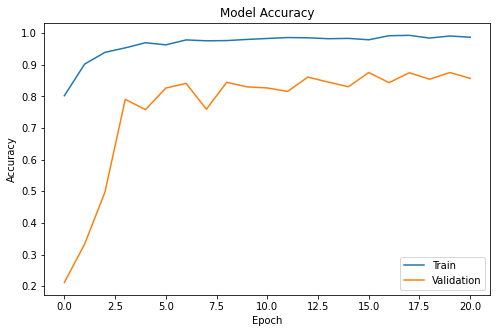

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.xlim((1, 15))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
train_preds = model.predict(X_train,verbose = 1,batch_size = 32)
test_preds = model.predict(X_test,verbose = 1,batch_size = 32)

2645/2645 [==============================] - 45s 17ms/step


In [ ]:
train_labels = np.argmax(train_preds, axis=1)
test_labels = np.argmax(test_preds, axis=1)

In [ ]:
print("Train Accuracy score : %.3f" % accuracy_score(np.argmax(y_train_encoded,axis = 1),train_labels))
print("Test Accuracy score : %.3f" % accuracy_score(np.argmax(y_test_encoded,axis = 1),test_labels))

Train Accuracy score : 0.988
Test Accuracy score : 0.875


In [ ]:
model.save('model1.h5')

#  <font color='red'>Use Data Augmentations (Numpy array Iterator) (To improve generalization ability of model)</font>

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 10,horizontal_flip = True,zoom_range = 1)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train,y_train_encoded,batch_size = 32)
test_generator = test_datagen.flow(X_test,y_test_encoded,batch_size = 32)
print(train_generator.n,test_generator.n)

7920 2645


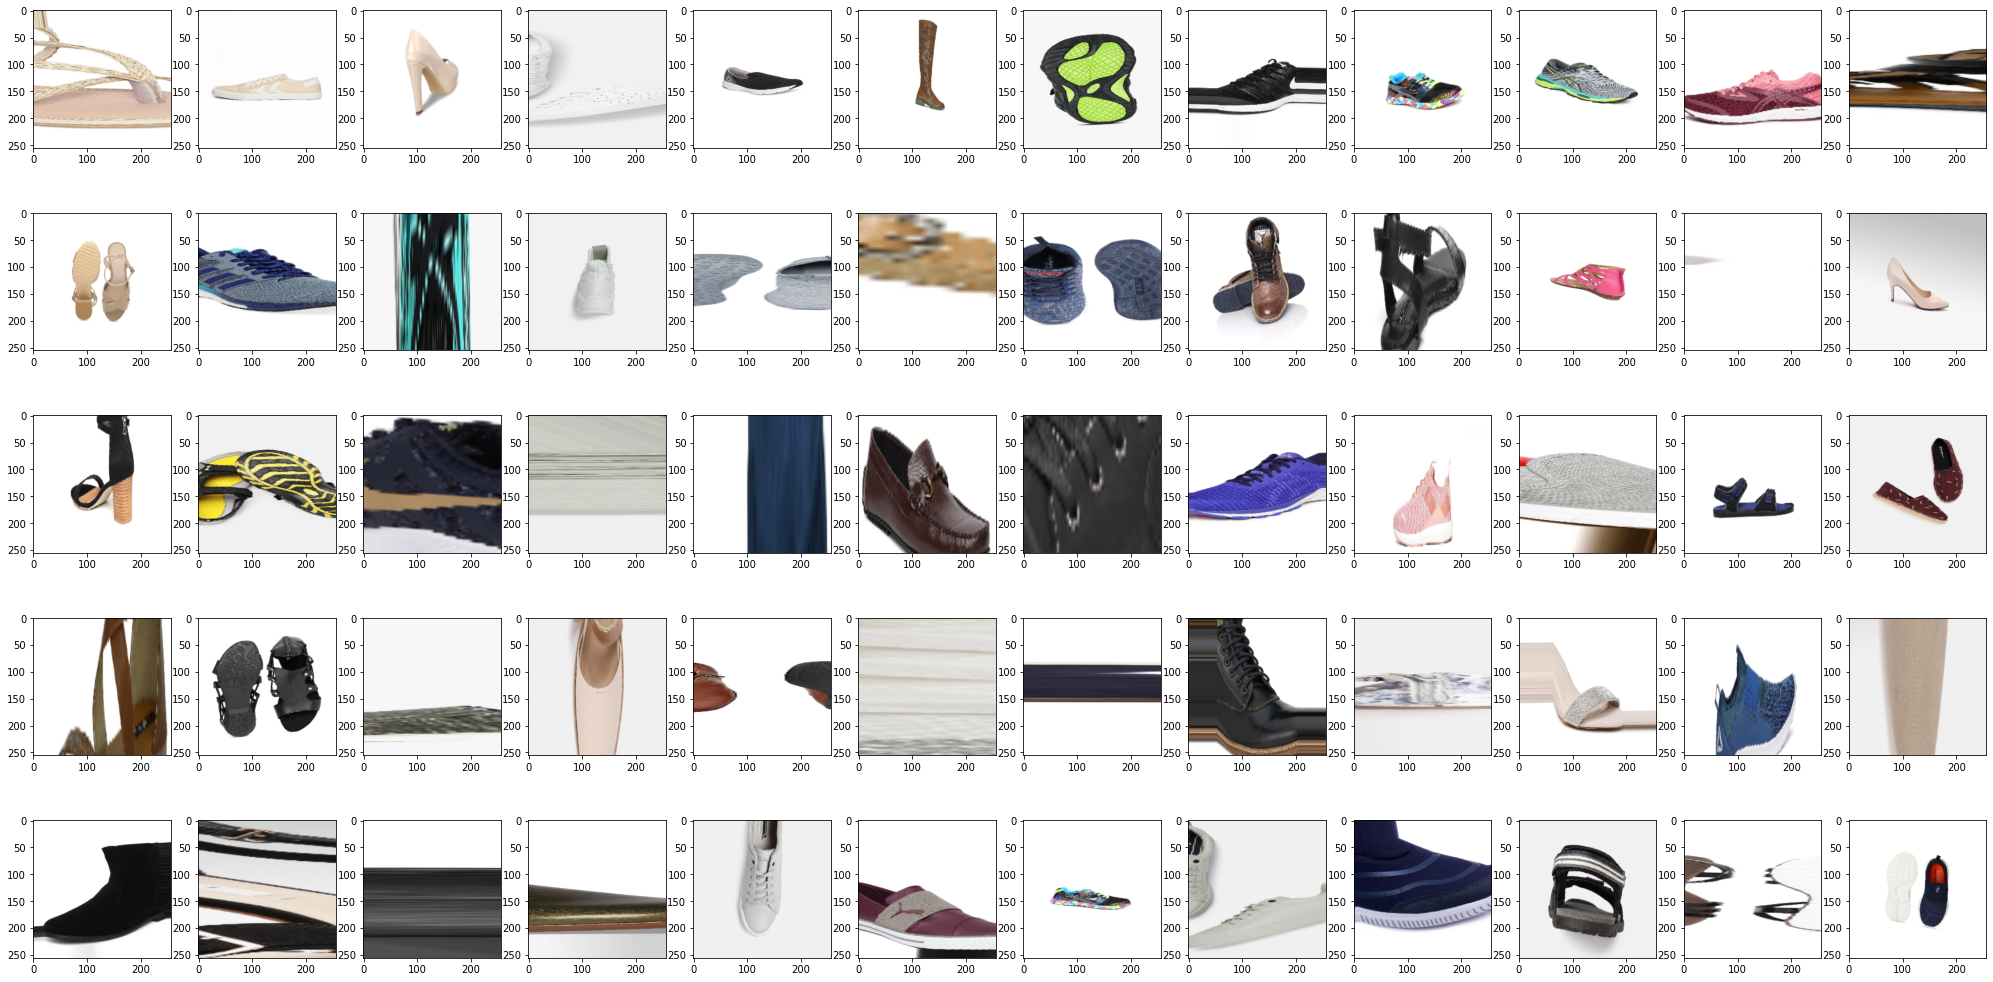

In [ ]:
f, axarr = plt.subplots(5,12,figsize = (35,18))
for i in range(5):
  for j in range(12):
    for img in train_generator:
      axarr[i][j].imshow(np.squeeze(img[0],0))
      break

In [ ]:
input_tensor = Input(shape=(256,256,3))
base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
final_output = Dense(6,kernel_regularizer= keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='softmax', name='final_output')(x)
model = Model(input_tensor, final_output)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [ ]:
for layer in model.layers:
  layer.trainable = False

for i in range(-4, 0):
  model.layers[i].trainable = True

In [ ]:
model.compile(loss=categorical_crossentropy,optimizer=optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
history1 = model.fit_generator(generator = train_generator,
                               steps_per_epoch=train_generator.n//train_generator.batch_size,
                               epochs=2,
                               verbose=1,
                               validation_data=test_generator,
                               validation_steps=test_generator.n//test_generator.batch_size)

Epoch 1/2
247/247 [==============================] - 299s 1s/step - loss: 1.3603 - accuracy: 0.4811 - val_loss: 2.0580 - val_accuracy: 0.2123
Epoch 2/2
247/247 [==============================] - 331s 1s/step - loss: 1.1433 - accuracy: 0.5458 - val_loss: 1.8251 - val_accuracy: 0.2162


In [ ]:
for layer in model.layers:
  layer.trainable = True

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

model.summary()
model.compile(loss=categorical_crossentropy,optimizer=optimizers.Adam(lr=1e-4),metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
history2 = model.fit_generator(generator = train_generator,
                               steps_per_epoch=train_generator.n//train_generator.batch_size,
                               epochs=40,
                               verbose=1,
                               validation_data=test_generator,
                               callbacks = [es,rlop],
                               validation_steps=test_generator.n//test_generator.batch_size)

Epoch 1/40
247/247 [==============================] - 357s 1s/step - loss: 0.9939 - accuracy: 0.6221 - val_loss: 2.1143 - val_accuracy: 0.2005
Epoch 2/40
247/247 [==============================] - 414s 2s/step - loss: 0.8117 - accuracy: 0.6942 - val_loss: 2.8384 - val_accuracy: 0.2637
Epoch 3/40
247/247 [==============================] - 392s 2s/step - loss: 0.7446 - accuracy: 0.7277 - val_loss: 2.2874 - val_accuracy: 0.4233
Epoch 4/40
247/247 [==============================] - 391s 2s/step - loss: 0.6843 - accuracy: 0.7457 - val_loss: 1.5011 - val_accuracy: 0.6368
Epoch 5/40
247/247 [==============================] - 384s 2s/step - loss: 0.6365 - accuracy: 0.7651 - val_loss: 0.7361 - val_accuracy: 0.7639
Epoch 6/40
247/247 [==============================] - 407s 2s/step - loss: 0.6223 - accuracy: 0.7685 - val_loss: 0.4917 - val_accuracy: 0.8263
Epoch 7/40
247/247 [==============================] - 408s 2s/step - loss: 0.5784 - accuracy: 0.7851 - val_loss: 0.6020 - val_accuracy: 0.8450

In [ ]:
train_preds = model.predict_generator(train_generator,verbose = 1)
test_preds = model.predict_generator(test_generator,verbose = 1)

83/83 [==============================] - 82s 984ms/step


In [ ]:
train_labels = np.argmax(train_preds, axis=1)
test_labels = np.argmax(test_preds, axis=1)

In [ ]:
print("Train Accuracy score : %.3f" % accuracy_score(np.argmax(y_train_encoded,axis = 1),train_labels))
print("Test Accuracy score : %.3f" % accuracy_score(np.argmax(y_test_encoded,axis = 1),test_labels))

Train Accuracy score : 0.988
Test Accuracy score : 0.875


#  <font color='red'>Hyperparameter tuning - Summary and conclusions</font>

In [ ]:
x = PrettyTable()
x.field_names = ["Model","Hyperparameters","Train Acc","Test Acc"]

x.add_row(["Baseline CNN","(dense=2048,p1=0.2,p2=0.25)",96.3, 84.2])
x.add_row(["reduce overfit CNN","(dense=512,p1=0.3,p2=0.4)",92.9, 83.3])
x.add_row(["reduce overfit CNN","(dense=512,p1=0.3,p2=0.4),L1=1e-5,L2=1e-4",98.8,87.5])
x.add_row(["Add Image Augmentations","hor_flip=T,rot=20,zoom=1",98.8,87.5])

print(x)

+-------------------------+-------------------------------------------+-----------+----------+
|          Model          |              Hyperparameters              | Train Acc | Test Acc |
+-------------------------+-------------------------------------------+-----------+----------+
|       Baseline CNN      |        (dense=2048,p1=0.2,p2=0.25)        |    96.3   |   84.2   |
|    reduce overfit CNN   |         (dense=512,p1=0.3,p2=0.4)         |    92.9   |   83.3   |
|    reduce overfit CNN   | (dense=512,p1=0.3,p2=0.4),L1=1e-5,L2=1e-4 |    98.8   |   87.5   |
| Add Image Augmentations |          hor_flip=T,rot=20,zoom=1         |    98.8   |   87.5   |
+-------------------------+-------------------------------------------+-----------+----------+


**OBSERVATIONS & CONCLUSIONS**
1. Test accuracy increased when using L1, L2 ElasticNet regularizer in the last dense layer
2. The L1 and L2 'lambda' values can be further hyperparameter tuned for further increments in accuracy
3. No significant improvements in train & test accuracy observed by using Image-augmentations